In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoModel
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [22]:

# Configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 512
DROPOUT_RATE = 0.3
FREEZE_LAYERS = True
FREEZE_EMBEDDINGS = True
FREEZE_EARLY_LAYERS = 6


BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 3
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0


VALIDATION_SPLIT = 0.2
DATASET_NAME = "fancyzhx/ag_news"
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label'

RANDOM_SEED = 42
NUM_WORKERS = 2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_PATH = '/kaggle/working/checkpoints'



In [ ]:
# custome classification dataset
class ClfDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length=512):
    self.texts= texts
    self.labels= labels
    self.tokenizer= tokenizer
    self.max_length= max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]

    encoding = self.tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=self.max_length,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype= torch.long)
    }

In [6]:
# tokenizer setup
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:


def load_ag_news_dataset():
  try:
      # load dataset
      dataset = load_dataset(DATASET_NAME )
      train_ds = dataset['train']
      test_ds = dataset['test']

      # convert to dataframe
      train_df = pd.DataFrame(train_ds)
      test_df = pd.DataFrame(test_ds)

      # Create id2label and label2id mappings
      label_feature = dataset['train'].features['label']
      label_names = label_feature.names
      id2label = {i: name for i, name in enumerate(label_names)}
      label2id = {name: i for i, name in enumerate(label_names)}

      # printing some infos
      print('Dataset loaded successfully')
      print(f'Training samples length: {len(train_df)}')
      print(f'Test samples length: {len(test_df)}')
      print(f'Dataset columns: {train_df.columns.tolist()}')
      print(f'Label mappings: {id2label}')
      print(f'First samples:\n{train_df.head(2)}')

      return train_df, test_df, id2label, label2id

  except Exception as e:
      print(f"Error loading dataset: {e}")
      return None, None, None, None


In [8]:
train_df, test_df, id2label, label2id = load_ag_news_dataset()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset loaded successfully
Training samples length: 120000
Test samples length: 7600
Dataset columns: ['text', 'label']
Label mappings: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
First samples:
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2


In [9]:
# prepare dataloader
def prepare_dataloader():
  texts = train_df[TEXT_COLUMN].tolist()
  labels = train_df[LABEL_COLUMN].tolist()

  train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED)

  train_dataset = ClfDataset(train_texts, train_labels, tokenizer)
  val_dataset = ClfDataset(val_texts, val_labels, tokenizer)

  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

  return train_dataloader, val_dataloader

In [10]:
train_dataloader, val_dataloader = prepare_dataloader()

In [11]:
# check dataloaders
for batch in train_dataloader:
  print(f"Batch input_ids shape: {batch['input_ids'].shape}")
  print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
  print(f"Batch labels shape: {batch['labels'].shape}")
  break


Batch input_ids shape: torch.Size([32, 512])
Batch attention_mask shape: torch.Size([32, 512])
Batch labels shape: torch.Size([32])


In [12]:
class BERTClassifier(nn.Module):
  def __init__(self, model_name= None, num_classes=None, dropout_rate=None):
    super(BERTClassifier, self).__init__()
    model_name = model_name or MODEL_NAME
    dropout_rate = dropout_rate or DROPOUT_RATE

    self.bert = AutoModel.from_pretrained(model_name)
    self.dropout = nn.Dropout(dropout_rate)
    self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    if FREEZE_LAYERS:
      self.freeze_layers()

  def freeze_layers(self):
    if FREEZE_EMBEDDINGS:
      for param in self.bert.embeddings.parameters():
          param.requires_grad = False

    if FREEZE_EARLY_LAYERS > 0:
      for layer in self.bert.encoder.layer[:FREEZE_EARLY_LAYERS]:
        for param in layer.parameters():
            param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits


  def get_model_info(self):
    total_params = sum(p.numel() for p in self.parameters())
    trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

    return {
      'total_params': total_params,
      'trainable_params': trainable_params,
      'frozen_params': total_params - trainable_params
    }


In [13]:
model = BERTClassifier(num_classes=len(label2id)).to(DEVICE)

2025-06-28 20:14:15.231391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751141655.493770      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751141655.565425      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
info = model.get_model_info()
print(f"Model created with {len(label2id)} classes")
print(f"Total parameters: {info['total_params']:,}")
print(f"Trainable parameters: {info['trainable_params']:,}")
print(f"Frozen parameters: {info['frozen_params']:,}")


Model created with 4 classes
Total parameters: 109,485,316
Trainable parameters: 43,120,900
Frozen parameters: 66,364,416


In [15]:

# initialize optimizer, scheduler, loss funcrion
optimizer = AdamW(
    model.parameters(),
    lr = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY
)

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(WARMUP_RATIO * total_steps),
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss()

In [16]:
# train one epoch
def train_epoch(train_dataloader):
  model.train()
  total_loss = 0.0

  train_progress = tqdm(train_dataloader, desc="Training")
  for batch in train_progress:
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)

    optimizer.zero_grad()

    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits, labels)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

    optimizer.step()
    scheduler.step()

    total_loss += loss.item()
    train_progress.set_postfix({'loss': loss.item()})

  avg_loss = total_loss / len(train_dataloader)
  print(f"Training Loss: {avg_loss}")
  return avg_loss


In [17]:
# evaluation fun
def evaluate(val_dataloader):
  model.eval()
  total_loss = 0.0
  all_predictions = []
  all_labels = []
  val_progress = tqdm(val_dataloader, desc="Validation")

  with torch.no_grad():
    for batch in val_progress:
      input_ids = batch['input_ids'].to(DEVICE)
      attention_mask = batch['attention_mask'].to(DEVICE)
      labels = batch['labels'].to(DEVICE)


      logits = model(input_ids, attention_mask)
      loss = loss_fn(logits, labels)

      total_loss += loss.item()
      val_progress.set_postfix({'loss': loss.item()})

      prediction = torch.argmax(logits, dim=1)
      all_predictions.extend(prediction.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  avg_loss = total_loss / len(val_dataloader)
  accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
  print(f"Validation Loss: {avg_loss}")
  print(f"Validation Accuracy: {accuracy}")

  return avg_loss, accuracy



In [23]:

def save_checkpoint(model, optimizer, epoch, loss, filename):
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss
  }
  torch.save(checkpoint, filename)

In [24]:
# training loop
def train(train_dataloader, val_dataloader, epochs=EPOCHS, start_epoch=0):
  # Training history
  train_losses = []
  val_losses = []
  val_accuracies = []
  best_val_accuracy = 0

  for epoch in range(start_epoch, epochs):
    train_loss = train_epoch(train_dataloader)
    val_loss, val_accuracy = evaluate(val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      print(f"Best validation accuracy: {best_val_accuracy}")

    save_checkpoint(model, optimizer, epoch, val_loss, CHECKPOINT_PATH)
  print(f"\nTraining completed!")
  print(f"Best validation accuracy: {best_val_accuracy:.4f}")

  return {
      'train_losses': train_losses,
      'val_losses': val_losses,
      'val_accuracies': val_accuracies,
      'best_val_accuracy': best_val_accuracy
  }



In [25]:
training = train(train_dataloader, val_dataloader, epochs=EPOCHS)


Training: 100%|██████████| 3000/3000 [1:36:43<00:00,  1.93s/it, loss=0.345] 


Training Loss: 0.3188335629059002


Validation: 100%|██████████| 750/750 [12:15<00:00,  1.02it/s, loss=0.043] 


Validation Loss: 0.1770619990279277
Validation Accuracy: 0.9390416666666667
Best validation accuracy: 0.9390416666666667


Training: 100%|██████████| 3000/3000 [1:36:35<00:00,  1.93s/it, loss=0.208]  


Training Loss: 0.16249872469653687


Validation: 100%|██████████| 750/750 [12:14<00:00,  1.02it/s, loss=0.0415] 


Validation Loss: 0.1690808312135438
Validation Accuracy: 0.944375
Best validation accuracy: 0.944375


Training: 100%|██████████| 3000/3000 [1:36:31<00:00,  1.93s/it, loss=0.129]  


Training Loss: 0.12443325094413012


Validation: 100%|██████████| 750/750 [12:15<00:00,  1.02it/s, loss=0.0559] 


Validation Loss: 0.16481090730056167
Validation Accuracy: 0.94575
Best validation accuracy: 0.94575

Training completed!
Best validation accuracy: 0.9457


In [48]:
torch.save(model.state_dict(), '/kaggle/working/bert_clf_model.pt')

In [53]:
!tar -czvf bert_model_clf.tar /kaggle/working/bert_clf_model.pt

tar: Removing leading `/' from member names
/kaggle/working/bert_clf_model.pt


In [52]:
from IPython.display import FileLink, display
display(FileLink('bert_clf_model.tar.gz'))

/kaggle/working/bert_clf_model.tar.gz

In [54]:
torch.save(optimizer.state_dict(), '/kaggle/working/bert_clf_optim.pt')

In [55]:
!tar -czvf bert_clf_optim.tar /kaggle/working/bert_clf_optim.pt

tar: Removing leading `/' from member names
/kaggle/working/bert_clf_optim.pt


In [58]:
from IPython.display import FileLink, display
display(FileLink('bert_clf_model.pt'))

/kaggle/working/bert_clf_model.pt

## **Model Evaluation**

In [59]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
# prepare test dataset
test_texts = test_df[TEXT_COLUMN].tolist()
test_labels = test_df[LABEL_COLUMN].tolist()

test_dataset = ClfDataset(test_texts, test_labels, tokenizer)

test_dataloader= DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [66]:
# check test dataloaders
for batch in test_dataloader:
  print(f"Batch input_ids shape: {batch['input_ids'].shape}")
  print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
  print(f"Batch labels shape: {batch['labels'].shape}")
  break


Batch input_ids shape: torch.Size([32, 512])
Batch attention_mask shape: torch.Size([32, 512])
Batch labels shape: torch.Size([32])


In [75]:
def model_evaluation(model, test_dataloader, device, id2label):
    model.eval()
    total_loss = 0.0
    predictions=[]
    t_labels=[]
    test_progress = tqdm(test_dataloader, desc="Validation")

    with torch.no_grad():
        for batch in test_progress:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            test_progress.set_postfix({'loss': loss.item()})
            
            _, pred = torch.max(outputs, dim=1)

            predictions.extend(pred.cpu().tolist())
            t_labels.extend(labels.cpu().tolist())
            
    class_names = [id2label[i] for i in sorted(id2label.keys())]
    clf_report = classification_report(
        t_labels,
        predictions,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    conf_mat = confusion_matrix(
        t_labels,
        predictions
    )

    avg_loss = total_loss / len(test_dataloader)
    accuracy = np.mean(np.array(predictions) == np.array(t_labels))
    print(f"Test-Set Loss: {avg_loss}")
    print(f"Test-Set Accuracy: {accuracy}")

    return clf_report, conf_mat, predictions, t_labels

            
    


In [76]:
test = model_evaluation(model, test_dataloader, DEVICE, id2label)

Validation: 100%|██████████| 238/238 [03:54<00:00,  1.02it/s, loss=0.0108] 

Test-Set Loss: 0.17732521419084685
Test-Set Accuracy: 0.9423684210526316


In [80]:
clf_report, conf_mat = test[0],test[1]

In [81]:
clf_report

{'World': {'precision': 0.9577167019027484,
  'recall': 0.9536842105263158,
  'f1-score': 0.9556962025316456,
  'support': 1900},
 'Sports': {'precision': 0.9873684210526316,
  'recall': 0.9873684210526316,
  'f1-score': 0.9873684210526316,
  'support': 1900},
 'Business': {'precision': 0.9208400646203554,
  'recall': 0.9,
  'f1-score': 0.9103007718924675,
  'support': 1900},
 'Sci/Tech': {'precision': 0.9041517170681702,
  'recall': 0.9284210526315789,
  'f1-score': 0.9161256816411322,
  'support': 1900},
 'accuracy': 0.9423684210526316,
 'macro avg': {'precision': 0.9425192261609764,
  'recall': 0.9423684210526315,
  'f1-score': 0.9423727692794692,
  'support': 7600},
 'weighted avg': {'precision': 0.9425192261609764,
  'recall': 0.9423684210526316,
  'f1-score': 0.9423727692794692,
  'support': 7600}}

In [85]:

def print_metrics(clf_report, conf_mat, id2label):
    print(f"\nModel Accuracy: {clf_report['accuracy']:.2%}\n")
    
    # Print per-class metrics
    print("{:<15} {:<10} {:<10} {:<10}".format(
        "Class", "Precision", "Recall", "F1-Score"))
    print("-" * 45)
    
    for i, label in id2label.items():
        print("{:<15} {:<10.2%} {:<10.2%} {:<10.2%}".format(
            label,
            clf_report[label]['precision'],
            clf_report[label]['recall'],
            clf_report[label]['f1-score']
        ))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(conf_mat)

In [86]:
print_metrics(clf_report, conf_mat, id2label)


Model Accuracy: 94.24%

Class           Precision  Recall     F1-Score  
---------------------------------------------
World           95.77%     95.37%     95.57%    
Sports          98.74%     98.74%     98.74%    
Business        92.08%     90.00%     91.03%    
Sci/Tech        90.42%     92.84%     91.61%    

Confusion Matrix:
[[1812   11   40   37]
 [  11 1876    5    8]
 [  42    6 1710  142]
 [  27    7  102 1764]]


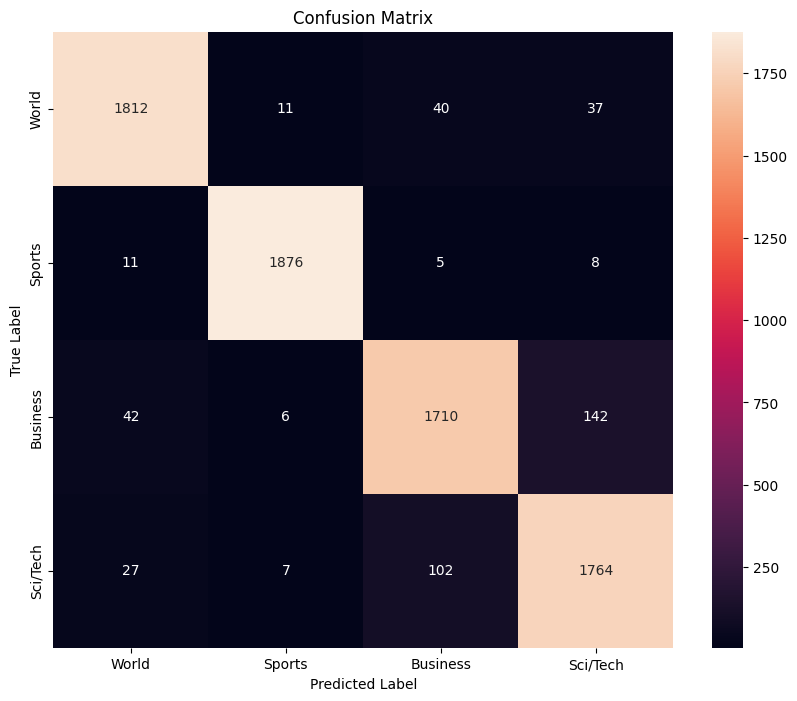

In [87]:

def plot_confusion_matrix(conf_mat, id2label):
    """Visualize confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', 
                xticklabels=id2label.values(),
                yticklabels=id2label.values())
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(conf_mat, id2label)

In [94]:
plt.savefig('/kaggle/working/confusion_matrix.png')


<Figure size 640x480 with 0 Axes>

In [95]:
display(FileLink('confusion_matrix.png'))

/kaggle/working/confusion_matrix.png